# Задача

Вам дан файл `beauty.csv`, в котором собраны несколько факторов про различных людей (мужчин и женщин): зарплата, опыт, цвет кожи, здоровье и т.д.

В последней колонке - целевое значение, которое требуется предсказать. Это то, как выглядит человек (красота) по шкале от 1 до 5. Принимаем, что это задача регрессии, т.е. на выходе могут получаться предикты вроде 3.6

Сначала нужно считать файл и убедиться, что все корректно сохранилось в таблицу.

In [1]:
import pandas as pd

In [2]:
with open('beauty.csv') as f:
    df = pd.read_csv(f, sep=';')

In [3]:
df.head()

,wage,exper,union,goodhlth,black,female,married,service,educ,looks
0,5.73,30,0,1,0,1,1,1,14,4
1,4.28,28,0,1,0,1,1,0,12,3
2,7.96,35,0,1,0,1,0,0,10,4
3,11.57,38,0,1,0,0,1,1,16,3
4,11.42,27,0,1,0,0,1,0,16,3


In [4]:
df.dtypes

wage        float64
exper         int64
union         int64
goodhlth      int64
black         int64
female        int64
married       int64
service       int64
educ          int64
looks         int64
dtype: object

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1260 entries, 0 to 1259
Data columns (total 10 columns):
wage        1260 non-null float64
exper       1260 non-null int64
union       1260 non-null int64
goodhlth    1260 non-null int64
black       1260 non-null int64
female      1260 non-null int64
married     1260 non-null int64
service     1260 non-null int64
educ        1260 non-null int64
looks       1260 non-null int64
dtypes: float64(1), int64(9)
memory usage: 98.5 KB


#### Вывести распределение таргета

Визуально определить, к какому распределению принадлежит эта величина

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

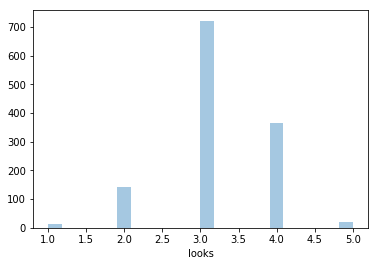

In [7]:
sns.distplot(df['looks'], kde=False)
plt.show()

Распределение целевого значения схложе с нормальным распределением 

#### Разделить выборку на train и test с помощью sklearn

А потом убедиться, что распределения таргетов в каждой выборке схожи.

In [8]:
X = df.values[:, 0:-1]
y = df.values[:, -1]

In [9]:
from sklearn import model_selection

In [10]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X,
    y, 
    test_size=0.33, 
    random_state=42,
)

In [11]:
X_train.shape

(844, 9)

In [12]:
X_test.shape

(416, 9)

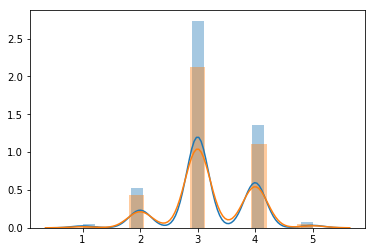

In [13]:
sns.distplot(y_train)
sns.distplot(y_test)
plt.show()

#### Провести регрессионный анализ

In [14]:
from sklearn import linear_model

lr = linear_model.LinearRegression()

In [15]:
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

Посмотрим на коэффициенты и свободный член

In [16]:
lr.coef_

array([ 0.00914542, -0.00847274, -0.0045655 ,  0.08089714,  0.07853578,
        0.04869817, -0.02100824, -0.03600616,  0.02962055])

In [17]:
lr.intercept_

2.833825636056823

#### Вывести с помощью barh значимость факторов

Что влияет сильнее всего? Слабее всего?

In [18]:
import numpy as np

In [19]:
coefs_arr = np.array(sorted(
    list(zip(df.columns[:-1], lr.coef_)), 
    key=lambda x: x[1],
    reverse=True,
))
coefs_arr

array([['goodhlth', '0.08089713562960461'],
       ['black', '0.07853577637113641'],
       ['female', '0.04869817457501933'],
       ['educ', '0.0296205544588485'],
       ['wage', '0.009145418127225078'],
       ['union', '-0.004565503445247946'],
       ['exper', '-0.008472735769112304'],
       ['married', '-0.021008242701595497'],
       ['service', '-0.03600616064495334']], dtype='<U21')

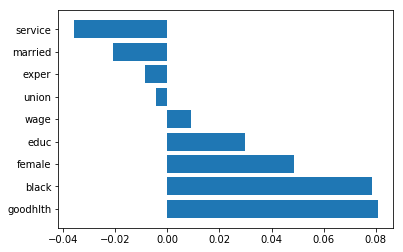

In [20]:
fig = plt.figure()
plt.barh(coefs_arr[:, 0], coefs_arr[:, 1].astype(float))
plt.show()

#### Посчитать ошибку (какую сочтете нужным)

In [21]:
from sklearn import metrics

In [22]:
predicts_test = np.rint(lr.predict(X_test))

In [23]:
metrics.mean_absolute_error(y_test, predicts_test)

0.4543269230769231

In [24]:
metrics.mean_squared_error(y_test, predicts_test)

0.49759615384615385

## Задание 2

Провести аналогичный регрессионный анализ, но реализовать Метод наименьших квадратов (МНК) самостоятельно, не используя функции библиотеки sklearn.

In [26]:
from scipy import optimize

In [108]:
ones = np.ones((X_test.shape[0],1))
val = np.hstack((X_test, ones))

In [109]:
def func_sq(a):
    y_pred = np.dot(val, a.T)
    MSE = np.square(np.subtract(y_pred, y_test)).mean() 
    return MSE

In [110]:
result = optimize.minimize(func_sq, np.zeros((1,10)), method='SLSQP')
print(result)

     fun: 0.4299775641056345
     jac: array([-0.00421105, -0.01376767, -0.00012078, -0.00031415, -0.00017459,
        0.000113  , -0.00055307, -0.0001036 , -0.00865408, -0.00058194])
 message: 'Optimization terminated successfully.'
    nfev: 235
     nit: 19
    njev: 19
  status: 0
 success: True
       x: array([ 0.01136017, -0.00618459, -0.11550162,  0.1012777 ,  0.0586034 ,
       -0.09624951, -0.10475042, -0.10413627,  0.03634134,  2.84792393])


## Задание 3

Добавить фактор looks_good(если looks больше 3, то 1, меньше 0)

Не использую looks предсказать использия логистическую регрессию looks_good

In [116]:
def looks_good(looks):
    return 1 if looks > 3 else 0

In [117]:
df['looks_good'] = df['looks'].apply(looks_good)
df.head()

,wage,exper,union,goodhlth,black,female,married,service,educ,looks,looks_good
0,5.73,30,0,1,0,1,1,1,14,4,1
1,4.28,28,0,1,0,1,1,0,12,3,0
2,7.96,35,0,1,0,1,0,0,10,4,1
3,11.57,38,0,1,0,0,1,1,16,3,0
4,11.42,27,0,1,0,0,1,0,16,3,0


In [134]:
df['looks_good'].sum()

383

In [149]:
X = df.values[:,:-2]
y = df['looks_good'].values

In [150]:
from sklearn import linear_model

In [151]:
logit = linear_model.LogisticRegression(
    C=10.0, 
    random_state=44, 
    solver='lbfgs',
)
logit.fit(X, y)

LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=44, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [153]:
logit.score(X, y)

0.6976190476190476